In [1]:
import yfinance as yf

ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')['Close']

/tmp/ipython-input-1561116617.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-01-01')['Close']
[*********************100%***********************]  1 of 1 completed


In [2]:
import numpy as np

returns = np.log(data / data.shift(1)).dropna()

In [3]:
split = int(len(returns) * 0.8)
train, test = returns[:split], returns[split:]

In [4]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

p = q = range(1, 11)
pq = list(itertools.product(p, q))
results = []

best_mse = float('inf')
best_order = None
best_forecast = None

for order in pq:
    try:
        model = ARIMA(train, order=(order[0], 0, order[1]))  # ARMA = ARIMA with d=0
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)

        # Track best model separately
        if mse < best_mse:
            best_mse = mse
            best_order = order
            best_forecast = forecast

        # Store result for plotting or analysis
        results.append({
            'order': order,
            'aic': model_fit.aic,
            'mse': mse
        })

    except:
        continue

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [5]:
import pandas as pd

results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['mse'].idxmin()]

In [6]:
print("Best ARMA(p,q) model based on forecast MSE:")
print(f"Order (p,q): {best_row['order']}")
print(f"AIC: {best_row['aic']:.2f}")
print(f"Out-of-sample MSE: {best_row['mse']:.6f}")

Best ARMA(p,q) model based on forecast MSE:
Order (p,q): (8, 4)
AIC: -3744.06
Out-of-sample MSE: 0.000138


/tmp/ipython-input-1896500186.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


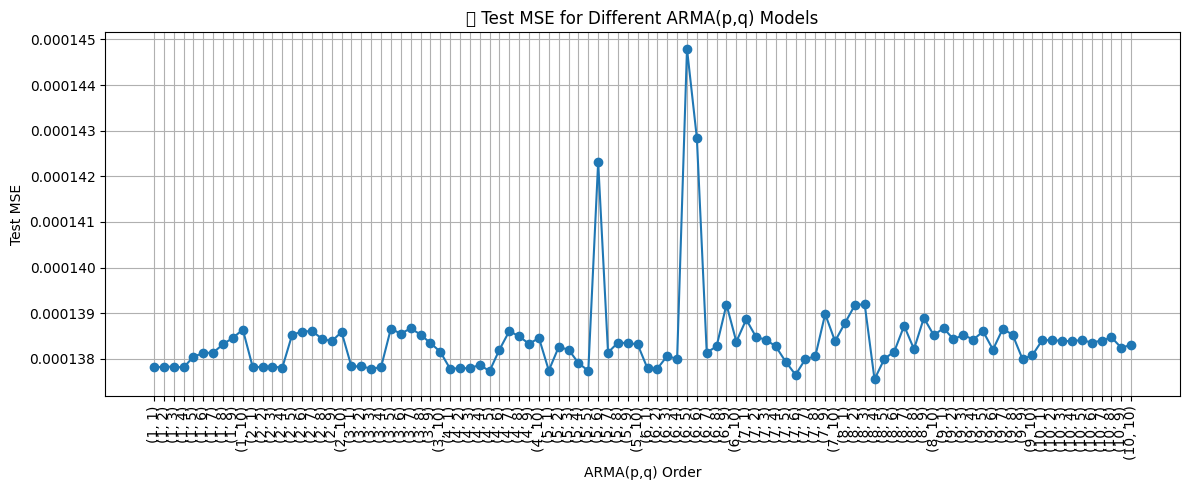

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
orders_str = [str(x['order']) for x in results]
plt.plot(orders_str, [x['mse'] for x in results], marker='o')
plt.xticks(rotation=90)
plt.xlabel('ARMA(p,q) Order')
plt.ylabel('Test MSE')
plt.title('📉 Test MSE for Different ARMA(p,q) Models')
plt.grid(True)
plt.tight_layout()
plt.show()

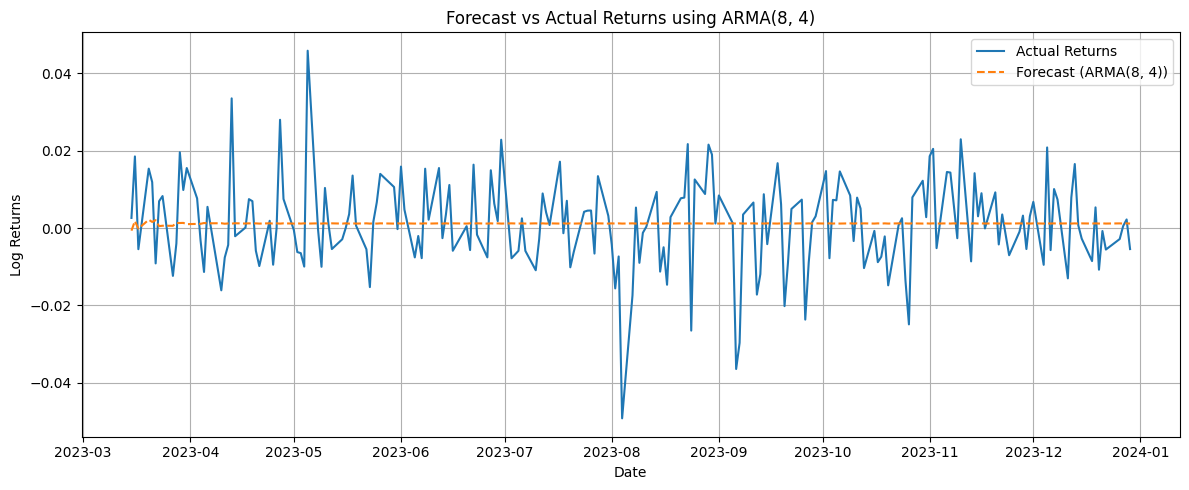

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual Returns')
plt.plot(test.index, best_forecast, label=f'Forecast (ARMA{best_order})', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title(f'Forecast vs Actual Returns using ARMA{best_order}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import traceback  # FIXED: now imported

# ----------------------------
# Parameters
# ----------------------------
start_date = '2022-03-01'
end_date   = '2024-05-31'
tickers = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]  # example
window_size = 90
forecast_horizon = 1
main_order = (1, 0, 1)   # primary ARIMA(p,d,q)
fallback_order = (1, 0, 0)  # simpler fallback
eps = 1e-8

# ----------------------------
# Download OHLCV
# ----------------------------
raw = yf.download(tickers, start=start_date, end=end_date,
                  interval="1d", group_by='ticker', threads=True)

# Handle MultiIndex from yfinance
if isinstance(raw.columns, pd.MultiIndex):
    close = pd.concat(
        [raw[t]['Close'].rename(t) for t in tickers if t in raw.columns.levels[0]],
        axis=1
    )
else:
    close = raw['Close'] if 'Close' in raw.columns else raw

# ----------------------------
# Percent returns
# ----------------------------
returns = close.pct_change().dropna()
returns = returns * 100  # percent form

# ----------------------------
# Rolling ARIMA forecasts
# ----------------------------
vol_forecast_dict = {}
avg_forecasted_vol_list = []

for ticker in tqdm(tickers, desc="ARIMA rolling forecasts"):
    if ticker not in returns.columns:
        vol_forecast_dict[ticker] = pd.Series(dtype=float)
        avg_forecasted_vol_list.append(np.nan)
        print(f"{ticker} missing from returns data.")
        continue

    sq_ret = (returns[ticker].dropna()) ** 2  # percent^2
    rolling_vols = []
    rolling_dates = []

    # Skip if not enough data
    if len(sq_ret) < window_size + 1:
        vol_forecast_dict[ticker] = pd.Series(dtype=float)
        avg_forecasted_vol_list.append(np.nan)
        print(f"{ticker} too short: {len(sq_ret)} obs.")
        continue

    for i in range(window_size, len(sq_ret)):
        train = sq_ret.iloc[i - window_size:i]

        # Skip if NaNs or too low variance
        if train.isnull().any():
            print(f"{ticker} window {i} skipped: NaNs in training window")
            continue
        if train.std() < 1e-4:  # higher threshold than before
            print(f"{ticker} window {i} skipped: low std ({train.std():.3e})")
            continue

        # Log-transform for ARIMA
        y = np.log(train + eps)

        def fit_and_forecast(order):
            """Helper to fit ARIMA and return predicted vol in %."""
            model = ARIMA(y, order=order)
            res = model.fit(method_kwargs={"warn_convergence": False})
            fc = res.forecast(steps=forecast_horizon)
            pred_log_var = float(fc.iloc[0])  # FIXED: safe indexing
            pred_var = np.exp(pred_log_var)   # percent^2
            return np.sqrt(pred_var)          # percent

        try:
            pred_vol = fit_and_forecast(main_order)
        except Exception as e:
            print(f"{ticker} window {i} MAIN ARIMA error: {type(e).__name__}, {repr(e)}")
            traceback.print_exc()
            # Try fallback model
            try:
                pred_vol = fit_and_forecast(fallback_order)
                print(f"{ticker} window {i}: used fallback ARIMA{fallback_order}")
            except Exception as e2:
                print(f"{ticker} window {i} FALLBACK ARIMA error: {type(e2).__name__}, {repr(e2)}")
                traceback.print_exc()
                continue  # skip if both fail

        # Sanity filter
        if not np.isnan(pred_vol) and pred_vol < 10:
            rolling_vols.append(pred_vol)
            rolling_dates.append(sq_ret.index[i])
        else:
            print(f"{ticker} window {i} skipped: pred_vol={pred_vol}")

    vol_series = pd.Series(rolling_vols, index=rolling_dates)
    vol_forecast_dict[ticker] = vol_series

    avg_forecasted_vol = np.nan if len(rolling_vols) == 0 else float(np.mean(rolling_vols))
    avg_forecasted_vol_list.append(avg_forecasted_vol)
    print(f"{ticker} avg forecasted vol (daily, %) = {avg_forecasted_vol}")

# ----------------------------
# Final results
# ----------------------------
vol_forecast_df = pd.DataFrame(vol_forecast_dict)
avg_forecasted_vol_df = pd.DataFrame({
    "Ticker": tickers,
    "Avg_Forecasted_DailyVol_%": avg_forecasted_vol_list
})

print("\nAverage forecasted vols:\n", avg_forecasted_vol_df)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `star

RELIANCE.NS avg forecasted vol (daily, %) = 0.6425597377545159


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 

HDFCBANK.NS avg forecasted vol (daily, %) = 0.5318230453560956


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when 

INFY.NS avg forecasted vol (daily, %) = 0.7845461330483282

Average forecasted vols:
         Ticker  Avg_Forecasted_DailyVol_%
0  RELIANCE.NS                   0.642560
1  HDFCBANK.NS                   0.531823
2      INFY.NS                   0.784546
